# Предсказание площади лесных пожаров

### Соколов Игорь


### Задание:

На основе погодных измерений необходимо предсказать объем выгоревших лесных массивов на севере Португалии. Выборка состоит из 13 признаков и 517 объектов. Для решения задачи предлагается использовать метод наименьших квадратов с регуляризацией. Нарисовать график весов признаков и общей ошибки на кросс-валидации при изменении параметра регуляризации. Какие признаки наиболее важны для нашей задачи? Что изменится, если предварительно все признаки стандартизовать?

In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
%matplotlib inline

Посмотрим на данные

In [41]:
raw_data = pd.read_csv("forestfires.csv")
raw_data.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Описание признаков:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
(this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).

Предобработка данных

In [6]:
print raw_data.shape
print raw_data.isnull().values.any()

(517, 13)
False


Типы признаков

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


Закодируем нечисловые признаки

In [40]:
month = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11,'dec':12}
day  = {'mon':1,  'tue':2,'wed':3,'thu':4, 'fri':5,'sat':6, 'sun':7}

In [45]:
df = raw_data.copy()

In [49]:
df['month'] = df['month'].apply (lambda x: month[x])
df['day'] = df['day'].apply (lambda x: day[x])

In [64]:
df['area'] = df['area'].apply(lambda x: math.log(x + 1))

In [65]:
df.head(5)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,2,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,6,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,3,5,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,3,7,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


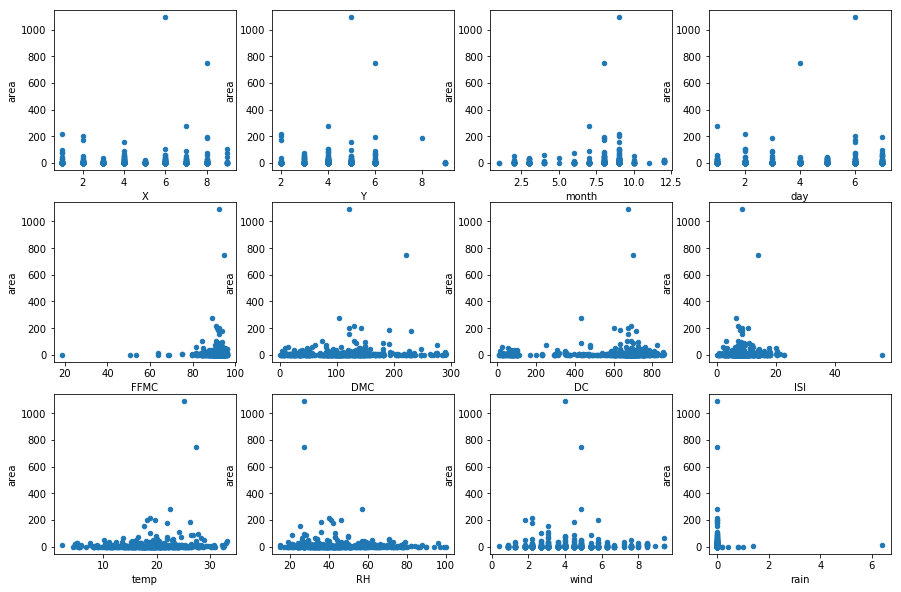

In [51]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "area", subplots=True, kind="scatter", ax=axes[idx / 4, idx % 4])

In [66]:
df.corrwith(df['area'])

X        0.061995
Y        0.038838
month    0.114280
day      0.000208
FFMC     0.046799
DMC      0.067153
DC       0.066360
ISI     -0.010347
temp     0.053487
RH      -0.053662
wind     0.066973
rain     0.023311
area     1.000000
dtype: float64

In [58]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

/home/igor/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [56]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["area"]

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

/home/igor/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [57]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(X, y,  
                                                                                     test_size = 0.3)
linear_regressor = LinearRegression()
linear_regressor.fit(train_data, train_labels)
predictions = linear_regressor.predict(test_data)

for name,coef in zip(df.columns,linear_regressor.coef_):
    print name,': ',coef

X :  5.67587987307
Y :  0.251287639457
month :  7.79130041309
day :  2.07075943449
FFMC :  -0.7686307682
DMC :  7.19138251292
DC :  -9.06946643636
ISI :  -4.33938661371
temp :  6.49816424441
RH :  -3.95754840207
wind :  3.00169859201
rain :  -0.993955540002


In [59]:
metrics.mean_absolute_error(test_labels,predictions)


15.658786797231997

In [62]:
test_labels

63      0.00
279     9.77
304     0.00
197    11.06
196    10.93
7       0.00
84      0.00
386    24.59
110     0.00
512     6.44
482     1.29
298     0.00
410     0.00
444     9.96
373     0.00
425     0.00
53      0.00
220    32.07
1       0.00
400     8.16
172     2.74
254    10.34
371     0.00
47      0.00
413     0.00
449     0.00
277    10.73
492     0.00
288     0.00
65      0.00
       ...  
287     0.00
46      0.00
249     2.47
141     0.55
378     0.00
109     0.00
445     0.00
487    16.40
193     9.41
75      0.00
175     4.53
359     8.12
509     2.17
476     1.76
77      0.00
160     1.75
360     1.09
147     0.96
472     1.94
42      0.00
455     0.00
174     3.50
495     0.00
299     0.00
133     0.00
178     4.88
139     0.43
221    35.88
426     0.00
437     0.00
Name: area, Length: 156, dtype: float64